In [1]:
# Importing experiment configs
import yaml
from box import Box
from comet_ml import Experiment

with open("configs/configs_abideI_n4.yml", "r") as ymlfile:
    cfg = Box(yaml.safe_load(ymlfile))

with open("configs/general_args.yml", "r") as ymlfile:
    general_args = yaml.safe_load(ymlfile)

In [2]:
# Create an experiment with your api key
experiment = Experiment(
    api_key = cfg.logging.comet_experiment_api,
    project_name = cfg.logging.comet_project_name,
    workspace = cfg.logging.comet_workspace,
)

experiment_name = f"aenc_{cfg.params.args.conv_model[-1]}_{cfg.params.args.learning_rate}_{cfg.params.n_sites}_sites/seed_{cfg.params.r_seed}" 
experiment.set_name(experiment_name)
experiment.log_dataset_info(cfg.params.dataset_info)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kondratevakate/fader-net-abide/277cab7586fe44149246fda1378651ed



In [3]:
# importing utils for training, logging and viz

from models import *
from viz import *
from utils import *
from train import *

In [4]:
# importing data
import torch 
save_folder = cfg.logging.weights_save_folder
selected_all_sum_tensor = torch.load(cfg.inputs.data)

if len(selected_all_sum_tensor.size()) < 5:
    selected_all_sum_tensor = selected_all_sum_tensor.unsqueeze(1).float()

selected_targets_tensor = torch.load(cfg.inputs.targets)
selected_sites_tensor = torch.load(cfg.inputs.sites)
selected_sexes_tensor = torch.load(cfg.inputs.sex)
selected_ages_tensor = torch.load(cfg.inputs.age)

In [5]:
# defining a training dataset with N_sites parametr from configs
n_sites = cfg.params.n_sites
site_codes = cfg.params.site_codes
code2site = {i : s for s, i in site_codes.items()}
site_labels = [code2site[i] for i in range(1, n_sites + 1)]

# manially cropping data to cubic format
### this should be manually corrected for each dataset used
img_crop = range(cfg.params.img_crop[0], cfg.params.img_crop[1])
selected_all_sum_tensor = selected_all_sum_tensor[..., :, img_crop, :]
selected_all_sum_tensor = torch.nn.functional.pad(selected_all_sum_tensor, pad=tuple(cfg.params.pad))
# asserting if shape mismatch
assert selected_all_sum_tensor.size()[2:] != cfg.params.img_size , f'Input shape is {selected_all_sum_tensor.size()[2:]},  doesnt match {cfg.params.img_size}'

In [6]:
# Decoding site names to use it as One Hot Encoded vectore while training
selected_sites_tensor_ohe = []
for v in selected_sites_tensor.unique():
    selected_sites_tensor_ohe.append((selected_sites_tensor == v).float())
selected_sites_tensor_ohe = torch.stack(selected_sites_tensor_ohe, dim=-1)

selected_sexes_tensor_ohe = []
for v in selected_sexes_tensor.unique():
    selected_sexes_tensor_ohe.append((selected_sexes_tensor == v).float())
selected_sexes_tensor_ohe = torch.stack(selected_sexes_tensor_ohe, dim=-1)

# Choosing top `n_sites` by size in dataset
selected_attrs_tensor = selected_sites_tensor_ohe[:, :n_sites]
selected_idx = selected_attrs_tensor.sum(axis=1).byte()

# Normalizing input vector prior to training
selected_all_sum_tensor = selected_all_sum_tensor - selected_all_sum_tensor.mean()
selected_all_sum_tensor = selected_all_sum_tensor/selected_all_sum_tensor.std()

In [7]:
#defining a random state and args

import random, numpy
r_seed = cfg.params.r_seed
random.seed(r_seed)
numpy.random.seed(r_seed)
torch.manual_seed(r_seed)
torch.cuda.manual_seed(r_seed)

args = {k : v for k, v in general_args.items()}
args.update(cfg.params.args)
# Updating variables to tuples and lists, after *yml read
args.update({'img_shape': tuple(args['img_shape'])})
args.update({'noises': list(np.zeros_like(
    list(args['conv_model'])))})
args.update({'n_attrs_outputs': [selected_attrs_tensor.size(1)]})
# args.update({'n_epochs': 10})
experiment.log_parameters(args)

In [8]:
# wriring dataloader for training on selected data
tensor_dataset = data.TensorDataset(selected_all_sum_tensor[selected_idx], 
                                    selected_targets_tensor[selected_idx],
                                    selected_attrs_tensor[selected_idx])
idx = np.arange(len(tensor_dataset))
train_idx = idx
val_idx = idx
train_loader = torch.utils.data.DataLoader(
    data.Subset(tensor_dataset, train_idx), batch_size=args["batch_size"], shuffle=True)
val_loader = torch.utils.data.DataLoader(
    data.Subset(tensor_dataset, val_idx), batch_size=args["batch_size"], shuffle=False)
# set target for domain classification
AE, D, AE_opt, D_opt = create_model(args)

EPOCH 4


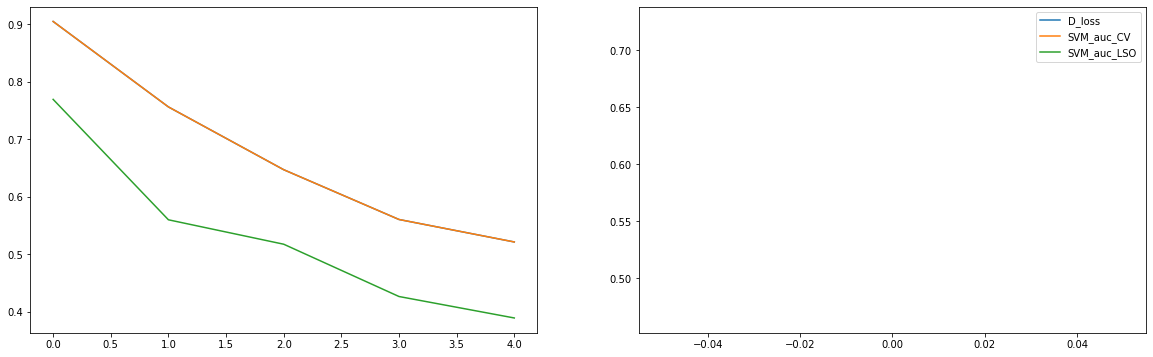

Train recon
tensor(13)


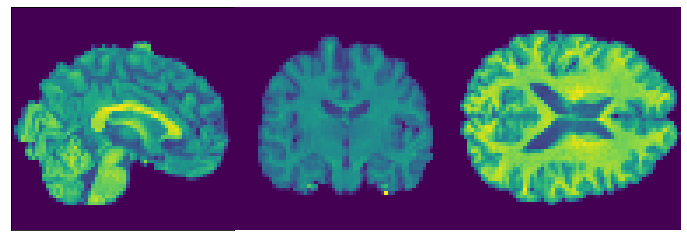

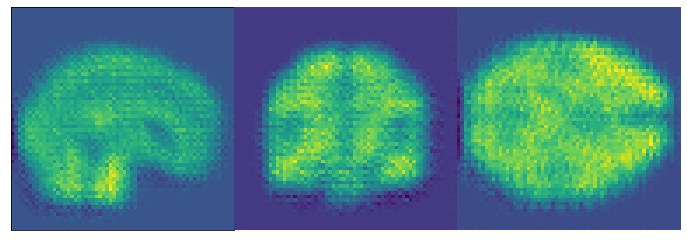

Val recon
tensor(17)


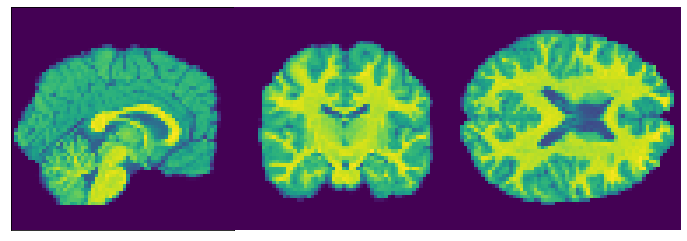

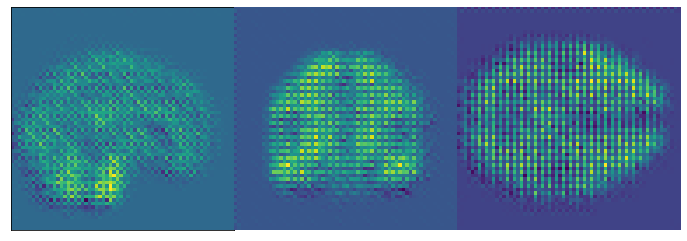

  AE loss: 			0.521351
  rec loss (in-iteration): 	0.521351
  D loss: 			0.725365
  val rec loss: 	0.389185
  SVM auc CV: 	0.503 (0.028)
  SVM auc LSO: 	0.465 (0.107)
NYU 0.493
UM_1 0.52
USM 0.617
UCLA_1 0.446
PITT 0.519
MAX_MUN 0.56
YALE 0.39
KKI 0.512
TRINITY 0.527
STANFORD 0.386
SDSU 0.604
LEUVEN_2 0.68
OLIN 0.287
UM_2 0.336
CALTECH 0.267
SBL 0.391
LEUVEN_1 0.367
OHSU 0.482
CMU 0.505
UCLA_2 0.408



  0%|          | 0/18 [00:00<?, ?it/s]

aenc_512_0.0001_20_sites/seed_0 saved to ./logfiles/weights/aenc_512_0.0001_20_sites/seed_0.pth
TRAIN EPOCH 5...
0


 67%|██████▋   | 12/18 [00:19<00:09,  1.61s/it]

In [ ]:
# training
train_stats = train_fadernet_sched(
                             train_loader, val_loader, args, 
                             AE, D, AE_opt, D_opt, device, 
                             AE_crit=nn.MSELoss(), 
                             D_crit=nn.BCEWithLogitsLoss(),
                             score_freq=cfg.params.save_vis_freq, 
                             vis_freq=cfg.params.save_vis_freq, 
                             site_labels=site_labels,
                             save_freq=cfg.params.save_vis_freq,
                             experiment_name = experiment_name,
    experiment = experiment,
    save_folder= cfg.logging.weights_save_folder) 